# **Project : Employee Sentiment Analysis**

Name: Shaidatullisa Nadia Binti Saipudin

## Introduction

This project focuses on understanding how employees feel based on the messages they send (like emails or internal communications). The goal is to find out which employees are happy, frustrated, or neutral in their communication, and how their mood changes over time. This can help the company support employees better, prevent issues early, and improve workplace culture.

To do this, I use techniques from Natural Language Processing (NLP). This techniques lets computers read and understand human language and data analysis tools like pandas, matplotlib, and scikit-learn.

The process is divided into 6 tasks:


*   Label each message with a sentiment (Positive, Negative, Neutral).
*   Explore the data to find patterns and problems
* Calculate how employees feel each month.
* Rank the happiest and most upset employees.
* Spot employees who may be at risk of quitting.
* Build a model that predicts how sentiment might change







## Imports and Setup

In [ ]:
# Install libraries
# !pip install transformers matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os
from IPython.display import display, Markdown

# Create output folders
os.makedirs('project_output/visualizations', exist_ok=True)


## Task 1: Sentiment Labeling

In this section, I took each message and used a pre-trained AI model to decide if the message is:

* Positive (e.g: “I love this project!”),
* Negative (e.g: “This is so frustrating.”)
* Neutral (e.g: “The meeting is at 3PM.”).

If the model isn't very sure about whether a message is Positive or Negative (confidence is below 60%), the model treat it as Neutral. This way, the model can avoid guessing wrong and keep the analysis more reliable.

**Why this is important:**

This step helps convert unstructured messages into structured data. Now, we can count how many positive or negative messages each person sends and analyze those trends.

In [ ]:
# Load raw dataset
df_raw = pd.read_csv('/content/test.csv')

# Initialize sentiment analysis pipeline
sentiment_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Run sentiment analysis
results = sentiment_pipe(df_raw['body'].astype(str).tolist())

# Apply threshold
sentiments = []
for res in results:
    label = res['label']
    score = res['score']
    if score < 0.6:
        sentiments.append('Neutral')
    else:
        sentiments.append('Positive' if label == 'POSITIVE' else 'Negative')

# Create a new DataFrame
df_sentiment = df_raw.copy()
df_sentiment['sentiment'] = sentiments

# Save sentiment-labeled dataset
df_sentiment.to_csv('project_output/sentiment_results.csv', index=False)

# Preview
display(Markdown("### Sentiment-Labeled Data Preview"))
display(df_sentiment[['body', 'sentiment']].head())

Device set to use cpu


### Sentiment-Labeled Data Preview

,body,sentiment
0,EnronOptions Announcement\n\n\nWe have updated...,Negative
1,"Marc,\n\nUnfortunately, today is not going to ...",Negative
2,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",Neutral
3,we were thinking papasitos (we can meet somewh...,Negative
4,Since you never gave me the $20 for the last t...,Positive


## Task 2: Exploratory Data Analysis

**What I Did:**
* Checked for missing or blank messages.
* Looked at the distribution of sentiments (how many are positive, negative, neutral).
* Tracked how sentiment changed month by month.
* Analyzed how many messages each employee sent.
* Calculated how often employees sent negative messages.

**Visuals Included:**
* Bar charts for sentiment types.
* Line graphs to show sentiment trends over time.
* Histograms showing how many messages employees sent and how negative they were.

**Why this is important:**

This step gives us a strong understanding of the data; where things are missing, what's normal, and what needs attention before deeper analysis. It also helps identify patterns in employee behavior.

<ipython-input-55-27f70937940b>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  empty_summary = df_analysis.applymap(lambda x: isinstance(x, str) and x.strip() == '').sum()


### 🕵️ Missing and Empty Values

,0
Subject,0
body,0
date,0
from,0
sentiment,0


,0
Subject,0
body,30
date,0
from,0
sentiment,0


<ipython-input-55-27f70937940b>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_analysis, x='sentiment', order=['Negative', 'Positive', 'Neutral'],palette='Set1')


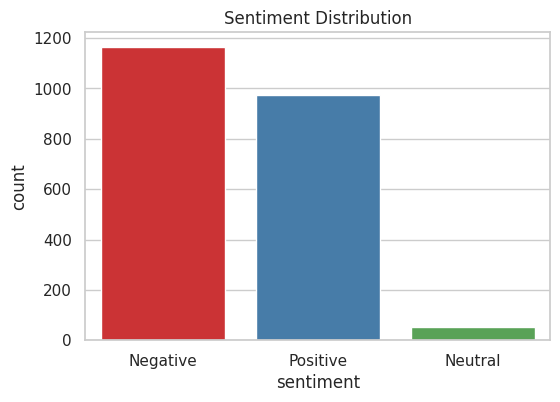

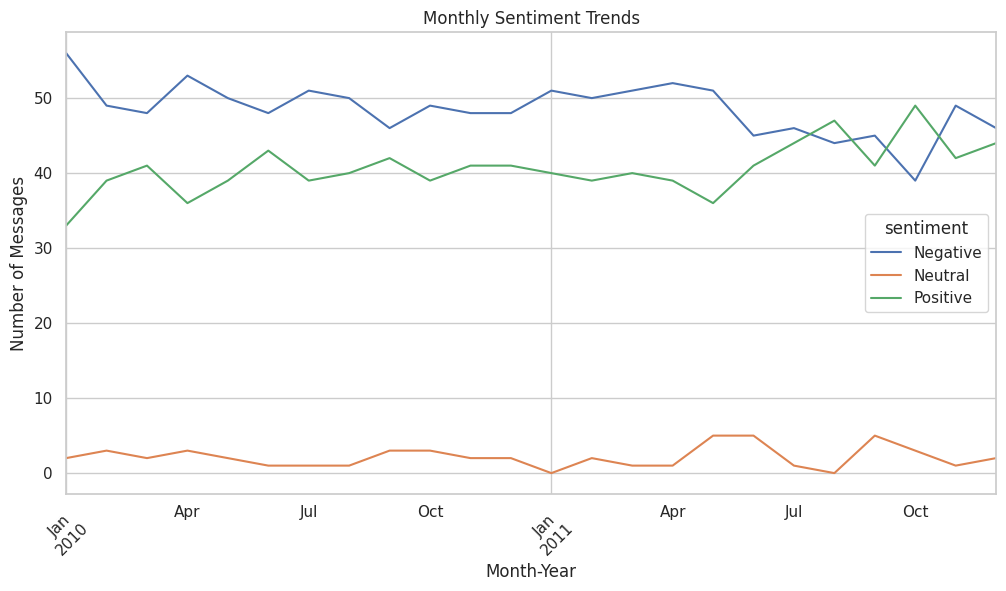

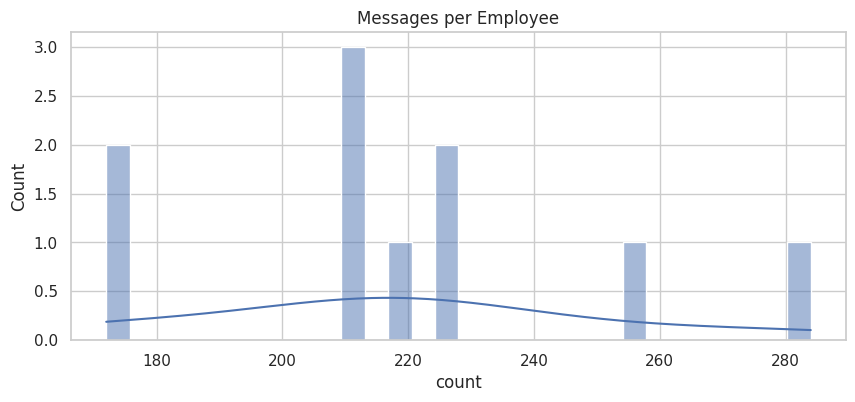

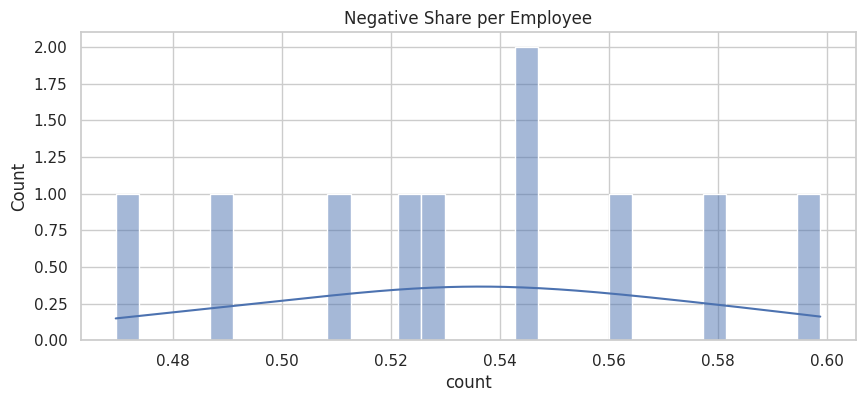

In [ ]:
# Load sentiment-labeled data for analysis
df_analysis = df_sentiment.copy()
df_analysis['date'] = pd.to_datetime(df_analysis['date'], errors='coerce')

# Check missing and empty values
missing_summary = df_analysis.isnull().sum()
empty_summary = df_analysis.applymap(lambda x: isinstance(x, str) and x.strip() == '').sum()

# Save EDA summary
with open('project_output/eda_summary.txt', 'w') as f:
    f.write("--- Missing Values ---\n")
    f.write(str(missing_summary))
    f.write("\n\n--- Empty String Counts ---\n")
    f.write(str(empty_summary))

display(Markdown("### 🕵️ Missing and Empty Values"))
display(missing_summary)
display(empty_summary)

# Sentiment distribution plot
plt.figure(figsize=(6, 4))
sns.countplot(data=df_analysis, x='sentiment', order=['Negative', 'Positive', 'Neutral'],palette='Set1')
plt.title('Sentiment Distribution')
plt.savefig('project_output/visualizations/sentiment_distribution.png')
plt.show()

# Monthly sentiment trends
df_analysis['month_year'] = df_analysis['date'].dt.to_period('M')
monthly_sentiment = df_analysis.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)

monthly_sentiment.plot(figsize=(12, 6))
plt.title('Monthly Sentiment Trends')
plt.xlabel('Month-Year')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.savefig('project_output/visualizations/monthly_sentiment_trends.png')
plt.show()

# Messages per employee
msg_counts = df_analysis['from'].value_counts()
plt.figure(figsize=(10, 4))
sns.histplot(msg_counts, bins=30, kde=True)
plt.title('Messages per Employee')
plt.savefig('project_output/visualizations/messages_per_employee.png')
plt.show()

# Negative share per employee
neg_counts = df_analysis[df_analysis['sentiment'] == 'Negative']['from'].value_counts()
neg_share = (neg_counts / msg_counts).fillna(0)
plt.figure(figsize=(10, 4))
sns.histplot(neg_share, bins=30, kde=True)
plt.title('Negative Share per Employee')
plt.savefig('project_output/visualizations/negative_share_per_employee.png')
plt.show()



## Task 3: Employee Score Calculations

**What I did:**

Each message was given a score:

* Positive = +1
* Negative = -1
* Neutral = 0

Then we added up these scores for each employee every month.

**Why this is important:**

This gives us a number that reflects how each employee’s mood changes over time. An employee with a high score sends mostly positive messages. A low (negative) score might suggest that person is stressed or upset.

In [ ]:
# Map sentiment to score
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df_analysis['sentiment_score'] = df_analysis['sentiment'].map(sentiment_map)
df_analysis['month_year'] = df_analysis['date'].dt.to_period('M')

# Aggregate monthly sentiment scores
monthly_scores = df_analysis.groupby(['from', 'month_year'])['sentiment_score'].sum().reset_index()

# Preview scores
display(Markdown("### Monthly Sentiment Scores"))
display(monthly_scores.head())

# Save to CSV
monthly_scores.to_csv('project_output/monthly_sentiment_scores.csv', index=False)


### Monthly Sentiment Scores

,from,month_year,sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,-2
1,bobette.riner@ipgdirect.com,2010-02,-3
2,bobette.riner@ipgdirect.com,2010-03,-3
3,bobette.riner@ipgdirect.com,2010-04,-2
4,bobette.riner@ipgdirect.com,2010-05,2


## Task 4: Employee Ranking

**What I Did:**

For every month, I made two lists:

* The Top 3 Positive employees: Those who had the highest total scores that month.
* The Top 3 Negative employees: Those with the lowest scores (most negative).

I sorted by sentiment score and then alphabetically to make it clear and fair.

**Visuals Included:**

Tables or charts that show who ranked in the top or bottom 3.

**Why this is important:**

This helps HR or managers easily identify the happiest and most frustrated team members. This insight can guide praise, rewards, or support.

### 2010-01 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,john.arnold@enron.com,3
1,johnny.palmer@enron.com,0
2,rhonda.denton@enron.com,-1


**Top Negative Employees**

,Employee,Sentiment Score
0,kayne.coulter@enron.com,-5
1,sally.beck@enron.com,-5
2,eric.bass@enron.com,-4


### 2010-02 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,don.baughman@enron.com,4
1,johnny.palmer@enron.com,1
2,lydia.delgado@enron.com,1


**Top Negative Employees**

,Employee,Sentiment Score
0,kayne.coulter@enron.com,-6
1,john.arnold@enron.com,-4
2,bobette.riner@ipgdirect.com,-3


### 2010-03 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,don.baughman@enron.com,2
1,kayne.coulter@enron.com,2
2,patti.thompson@enron.com,2


**Top Negative Employees**

,Employee,Sentiment Score
0,bobette.riner@ipgdirect.com,-3
1,eric.bass@enron.com,-3
2,john.arnold@enron.com,-3


### 2010-04 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,johnny.palmer@enron.com,5
1,eric.bass@enron.com,0
2,john.arnold@enron.com,0


**Top Negative Employees**

,Employee,Sentiment Score
0,kayne.coulter@enron.com,-6
1,patti.thompson@enron.com,-5
2,rhonda.denton@enron.com,-5


### 2010-05 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,bobette.riner@ipgdirect.com,2
1,kayne.coulter@enron.com,2
2,johnny.palmer@enron.com,1


**Top Negative Employees**

,Employee,Sentiment Score
0,don.baughman@enron.com,-7
1,lydia.delgado@enron.com,-4
2,patti.thompson@enron.com,-3


### 2010-06 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,johnny.palmer@enron.com,6
1,don.baughman@enron.com,3
2,sally.beck@enron.com,2


**Top Negative Employees**

,Employee,Sentiment Score
0,john.arnold@enron.com,-7
1,patti.thompson@enron.com,-6
2,kayne.coulter@enron.com,-2


### 2010-07 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,lydia.delgado@enron.com,2
1,bobette.riner@ipgdirect.com,0
2,sally.beck@enron.com,0


**Top Negative Employees**

,Employee,Sentiment Score
0,john.arnold@enron.com,-3
1,rhonda.denton@enron.com,-3
2,kayne.coulter@enron.com,-2


### 2010-08 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,don.baughman@enron.com,2
1,john.arnold@enron.com,2
2,sally.beck@enron.com,1


**Top Negative Employees**

,Employee,Sentiment Score
0,rhonda.denton@enron.com,-6
1,bobette.riner@ipgdirect.com,-5
2,lydia.delgado@enron.com,-2


### 2010-09 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,bobette.riner@ipgdirect.com,5
1,rhonda.denton@enron.com,3
2,patti.thompson@enron.com,2


**Top Negative Employees**

,Employee,Sentiment Score
0,eric.bass@enron.com,-6
1,john.arnold@enron.com,-5
2,johnny.palmer@enron.com,-4


### 2010-10 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,bobette.riner@ipgdirect.com,4
1,lydia.delgado@enron.com,2
2,kayne.coulter@enron.com,1


**Top Negative Employees**

,Employee,Sentiment Score
0,patti.thompson@enron.com,-9
1,johnny.palmer@enron.com,-5
2,rhonda.denton@enron.com,-2


### 2010-11 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,john.arnold@enron.com,4
1,lydia.delgado@enron.com,3
2,johnny.palmer@enron.com,1


**Top Negative Employees**

,Employee,Sentiment Score
0,patti.thompson@enron.com,-5
1,don.baughman@enron.com,-3
2,kayne.coulter@enron.com,-3


### 2010-12 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,sally.beck@enron.com,3
1,john.arnold@enron.com,1
2,kayne.coulter@enron.com,0


**Top Negative Employees**

,Employee,Sentiment Score
0,don.baughman@enron.com,-4
1,rhonda.denton@enron.com,-4
2,lydia.delgado@enron.com,-1


### 2011-01 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,johnny.palmer@enron.com,6
1,john.arnold@enron.com,1
2,kayne.coulter@enron.com,1


**Top Negative Employees**

,Employee,Sentiment Score
0,bobette.riner@ipgdirect.com,-5
1,rhonda.denton@enron.com,-5
2,sally.beck@enron.com,-4


### 2011-02 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,lydia.delgado@enron.com,3
1,eric.bass@enron.com,1
2,patti.thompson@enron.com,1


**Top Negative Employees**

,Employee,Sentiment Score
0,kayne.coulter@enron.com,-4
1,bobette.riner@ipgdirect.com,-3
2,sally.beck@enron.com,-3


### 2011-03 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,lydia.delgado@enron.com,5
1,johnny.palmer@enron.com,1
2,patti.thompson@enron.com,1


**Top Negative Employees**

,Employee,Sentiment Score
0,john.arnold@enron.com,-5
1,eric.bass@enron.com,-5
2,sally.beck@enron.com,-4


### 2011-04 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,eric.bass@enron.com,5
1,patti.thompson@enron.com,3
2,lydia.delgado@enron.com,2


**Top Negative Employees**

,Employee,Sentiment Score
0,kayne.coulter@enron.com,-9
1,bobette.riner@ipgdirect.com,-5
2,rhonda.denton@enron.com,-4


### 2011-05 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,lydia.delgado@enron.com,3
1,rhonda.denton@enron.com,2
2,johnny.palmer@enron.com,0


**Top Negative Employees**

,Employee,Sentiment Score
0,eric.bass@enron.com,-11
1,don.baughman@enron.com,-4
2,john.arnold@enron.com,-2


### 2011-06 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,johnny.palmer@enron.com,4
1,lydia.delgado@enron.com,2
2,sally.beck@enron.com,2


**Top Negative Employees**

,Employee,Sentiment Score
0,eric.bass@enron.com,-5
1,bobette.riner@ipgdirect.com,-3
2,rhonda.denton@enron.com,-2


### 2011-07 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,patti.thompson@enron.com,3
1,johnny.palmer@enron.com,2
2,rhonda.denton@enron.com,2


**Top Negative Employees**

,Employee,Sentiment Score
0,bobette.riner@ipgdirect.com,-4
1,don.baughman@enron.com,-3
2,john.arnold@enron.com,-2


### 2011-08 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,bobette.riner@ipgdirect.com,3
1,eric.bass@enron.com,3
2,lydia.delgado@enron.com,2


**Top Negative Employees**

,Employee,Sentiment Score
0,don.baughman@enron.com,-6
1,sally.beck@enron.com,-2
2,johnny.palmer@enron.com,-1


### 2011-09 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,johnny.palmer@enron.com,3
1,eric.bass@enron.com,3
2,rhonda.denton@enron.com,2


**Top Negative Employees**

,Employee,Sentiment Score
0,patti.thompson@enron.com,-5
1,bobette.riner@ipgdirect.com,-2
2,don.baughman@enron.com,-2


### 2011-10 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,kayne.coulter@enron.com,5
1,don.baughman@enron.com,4
2,sally.beck@enron.com,3


**Top Negative Employees**

,Employee,Sentiment Score
0,lydia.delgado@enron.com,-8
1,johnny.palmer@enron.com,0
2,rhonda.denton@enron.com,0


### 2011-11 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,patti.thompson@enron.com,5
1,don.baughman@enron.com,2
2,rhonda.denton@enron.com,1


**Top Negative Employees**

,Employee,Sentiment Score
0,kayne.coulter@enron.com,-5
1,bobette.riner@ipgdirect.com,-4
2,lydia.delgado@enron.com,-3


### 2011-12 Rankings

**Top Positive Employees**

,Employee,Sentiment Score
0,eric.bass@enron.com,3
1,john.arnold@enron.com,1
2,sally.beck@enron.com,1


**Top Negative Employees**

,Employee,Sentiment Score
0,bobette.riner@ipgdirect.com,-3
1,don.baughman@enron.com,-3
2,rhonda.denton@enron.com,-3


<ipython-input-56-5bc027526b69>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_positive_last, x='Employee', y='Score', palette='Set2')


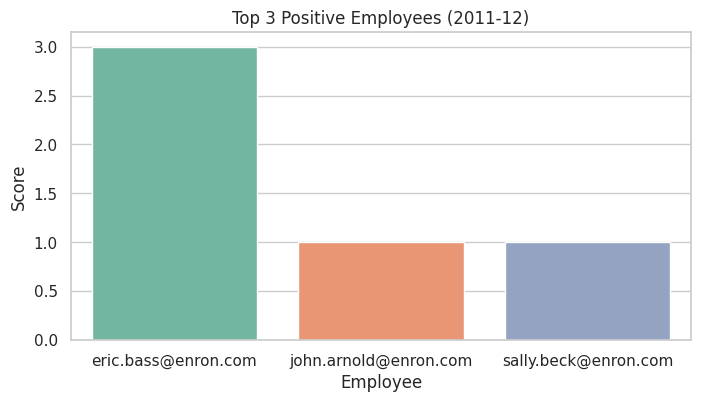

<ipython-input-56-5bc027526b69>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_negative_last, x='Employee', y='Score', palette='Set2')


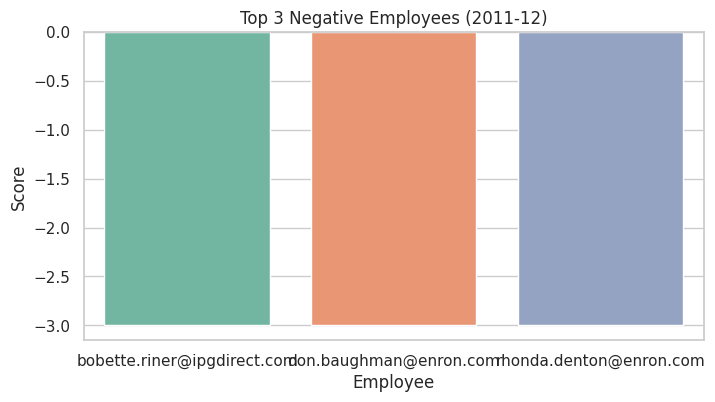

In [ ]:
# Function to rank employees
def rank_employees(df):
    top_pos, top_neg = {}, {}
    for month in df['month_year'].unique():
        month_data = df[df['month_year'] == month]
        pos = month_data.sort_values('sentiment_score', ascending=False).head(3)
        neg = month_data.sort_values('sentiment_score').head(3)
        top_pos[str(month)] = pos[['from', 'sentiment_score']].values.tolist()
        top_neg[str(month)] = neg[['from', 'sentiment_score']].values.tolist()
    return top_pos, top_neg

top_pos, top_neg = rank_employees(monthly_scores)

# Compile rankings into DataFrame
ranking_rows = []
for month in top_pos.keys():
    for emp, score in top_pos[month]:
        ranking_rows.append({'Month': month, 'Type': 'Top Positive', 'Employee': emp, 'Score': score})
    for emp, score in top_neg[month]:
        ranking_rows.append({'Month': month, 'Type': 'Top Negative', 'Employee': emp, 'Score': score})

rankings_df = pd.DataFrame(ranking_rows)

# Display rankings nicely
for month in top_pos.keys():
    display(Markdown(f"### {month} Rankings"))
    pos_df = pd.DataFrame(top_pos[month], columns=['Employee', 'Sentiment Score'])
    neg_df = pd.DataFrame(top_neg[month], columns=['Employee', 'Sentiment Score'])
    display(Markdown("**Top Positive Employees**"))
    display(pos_df)
    display(Markdown("**Top Negative Employees**"))
    display(neg_df)

# Save to CSV
rankings_df.to_csv('project_output/employee_rankings.csv', index=False)

# --- Bar Chart of Top Positive and Negative Employees (Last Month) ---
last_month = str(monthly_scores['month_year'].max())

# Prepare last month’s top rankings
top_positive_last = pd.DataFrame(top_pos.get(last_month, []), columns=['Employee', 'Score'])
top_negative_last = pd.DataFrame(top_neg.get(last_month, []), columns=['Employee', 'Score'])

# Plot positive
plt.figure(figsize=(8, 4))
sns.barplot(data=top_positive_last, x='Employee', y='Score', palette='Set2')
plt.title(f'Top 3 Positive Employees ({last_month})')
plt.savefig('project_output/visualizations/top_positive_employees.png')
plt.show()

# Plot negative
plt.figure(figsize=(8, 4))
sns.barplot(data=top_negative_last, x='Employee', y='Score', palette='Set2')
plt.title(f'Top 3 Negative Employees ({last_month})')
plt.savefig('project_output/visualizations/top_negative_employees.png')
plt.show()


## Task 5: Flight Risk Identification

**What I Did:**

We looked for employees who sent 4 or more negative messages within any 30-day window (not just per calendar month). This is called a rolling window, it always checks the most recent 30 days, no matter what the month is.

If someone met this condition, we flagged them as "flight risk", meaning they might be likely to leave the company soon.

**Why this is important:**

This is one of the most powerful tasks. It can help HR or leadership catch problems early and support at-risk employees before they decide to quit.

### Flight Risk Employees

,Employee
0,kayne.coulter@enron.com
1,lydia.delgado@enron.com
2,sally.beck@enron.com
3,don.baughman@enron.com
4,rhonda.denton@enron.com
5,bobette.riner@ipgdirect.com
6,patti.thompson@enron.com
7,john.arnold@enron.com
8,johnny.palmer@enron.com
9,eric.bass@enron.com


<ipython-input-53-3969da552414>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=neg_count_per_emp, x='Negative Message Count', y='Employee', order=neg_count_per_emp.sort_values('Negative Message Count', ascending=False)['Employee'], palette='Spectral')


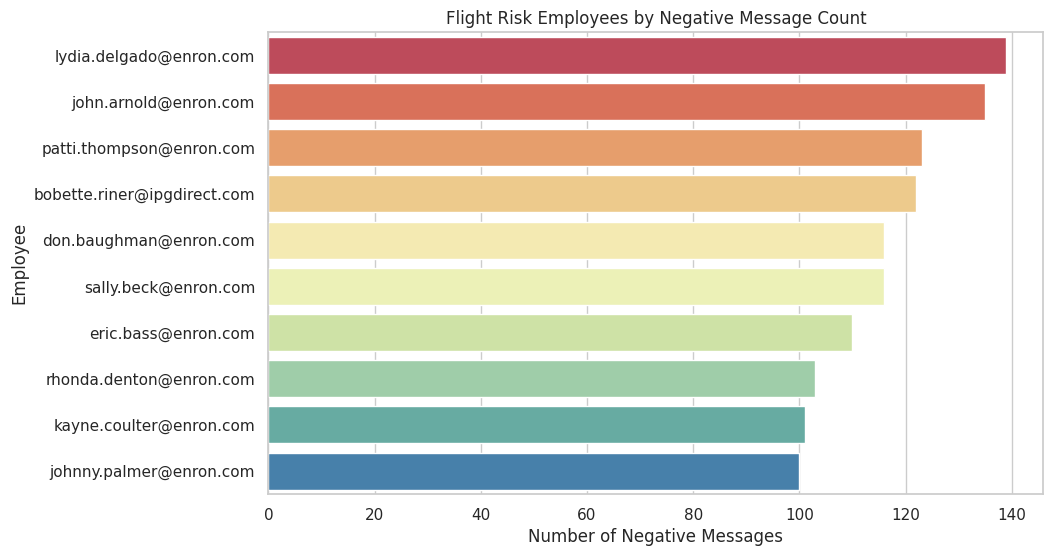

In [ ]:
# Identify flight risk (4+ negative messages in any rolling 30 days)
negatives = df_analysis[df_analysis['sentiment'] == 'Negative'][['from', 'date']]
flight_risks = set()

for emp in negatives['from'].unique():
    emp_data = negatives[negatives['from'] == emp].set_index('date').sort_index()
    rolling_counts = emp_data.rolling('30D').count()
    if (rolling_counts['from'] >= 4).any():
        flight_risks.add(emp)

# Convert to DataFrame
flight_risk_df = pd.DataFrame({'Employee': list(flight_risks)})

# Save to CSV
flight_risk_df.to_csv('project_output/flight_risk_employees.csv', index=False)

# Display
display(Markdown("### Flight Risk Employees"))
display(flight_risk_df)

# --- Count number of negative messages per flight risk employee ---
# Filter just flight risk employees
flight_risk_negatives = negatives[negatives['from'].isin(flight_risks)]

# Count negative messages (overall or in the recent 30-day window)
neg_count_per_emp = flight_risk_negatives['from'].value_counts().reset_index()
neg_count_per_emp.columns = ['Employee', 'Negative Message Count']

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(data=neg_count_per_emp, x='Negative Message Count', y='Employee', order=neg_count_per_emp.sort_values('Negative Message Count', ascending=False)['Employee'], palette='Spectral')
plt.title('Flight Risk Employees by Negative Message Count')
plt.xlabel('Number of Negative Messages')
plt.ylabel('Employee')
plt.savefig('project_output/visualizations/flight_risk_employees_by_risk.png')
plt.show()

## Task 6: Predictive Modeling

**What I Did:**

I built a mathematical model (Linear Regression) to predict how positive or negative an employee is in a given month, based on two key features:
* Average number of words per message → captures how much they write
* Average sentiment score per message → captures overall mood (positive, negative, or neutral)

I prepared the data by grouping it by employee and month, then splitting it into a training set (to teach the model) and a testing set (to check how well the model performs).

**Visuals Included:**

* Model evaluation metrics:
I report the Mean Squared Error (MSE) and R-squared (R²) to show how accurate the predictions are.

* Feature importance (coefficients):
I show how much each feature (average words, average sentiment) influences the predicted sentiment score.

* Predicted vs. Actual Plot:
I include a scatter plot comparing the model’s predicted sentiment scores to the actual scores, to visually assess how close the predictions are.

**Why This Is Important:**

This model helps us forecast sentiment trends across employees.
For example: If an employee’s average sentiment score drops (becomes more negative), or if their average word count sharply changes, the model can help flag these shifts and allow HR or management to step in early by providing support, improving communication, or investigating underlying issues before they escalate.

### Linear Regression (Avg Word Count + Sentiment Avg)

Mean Squared Error (MSE): 3.61
R-squared (R²): 0.52


,Feature,Coefficient
0,avg_word_count,0.007809
1,sentiment_score_avg,4.118446


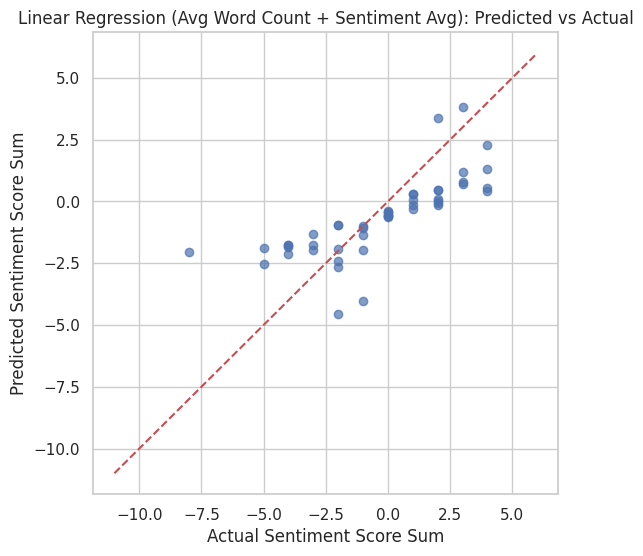

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# --- Feature Engineering ---
df_analysis['message_length'] = df_analysis['body'].astype(str).apply(len)
df_analysis['word_count'] = df_analysis['body'].astype(str).apply(lambda x: len(x.split()))

# Aggregate per employee per month
sentiment_agg = df_analysis.groupby(['from', 'month_year']).agg(
    sentiment_score_sum=('sentiment_score', 'sum'),
    sentiment_score_avg=('sentiment_score', 'mean'),
    avg_word_count=('word_count', 'mean')
).reset_index()

# --- Select Features and Target ---
X = sentiment_agg[['avg_word_count', 'sentiment_score_avg']]
y = sentiment_agg['sentiment_score_sum']

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Linear Regression Model ---
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)

# --- Evaluate ---
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lin_model.coef_})

# --- Save Outputs ---
coef_df.to_csv('project_output/model_coefficients_linear_sentiment_simple.csv', index=False)
with open('project_output/model_metrics_linear_sentiment_simple.txt', 'w') as f:
    f.write(f"Linear Regression Model (Avg Word Count + Sentiment Avg)\n")
    f.write(f"Mean Squared Error (MSE): {mse:.2f}\n")
    f.write(f"R-squared (R²): {r2:.2f}\n")

# --- Display Results ---
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

display(Markdown("### Linear Regression (Avg Word Count + Sentiment Avg)"))
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
display(coef_df)

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Sentiment Score Sum')
plt.ylabel('Predicted Sentiment Score Sum')
plt.title('Linear Regression (Avg Word Count + Sentiment Avg): Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.savefig('project_output/visualizations/predicted_vs_actual_linear_sentiment_simple.png')
plt.show()


###**Results and observation**

**Model Performance Metrics:**

Mean Squared Error (MSE): 3.61

This reflects the average squared difference between predicted and actual sentiment scores. a lower value indicates better predictive accuracy.

R-squared (R²): 0.52

The model explains approximately 52% of the variance in monthly sentiment score sums, indicating moderate predictive strength.

**Feature Coefficients:**

avg_word_count: 0.0078
sentiment_score_avg: 4.1184

**Interpretation:**

The avg_word_count coefficient is small but positive, suggesting that longer average messages slightly increase the predicted sentiment score, though its influence is minimal.

The sentiment_score_avg coefficient is large and positive, showing that the average sentiment per message is the strongest driver of overall monthly sentiment, as expected.

**Observation:**

While the model gives reasonable directional insights, its moderate R² suggests it misses part of the complex patterns in sentiment data, likely due to using only two basic features and the limitations of a linear approach.

##**Overall Key Insights**

1. Negative Sentiment Dominance:
Negative messages consistently outnumbered positive and neutral messages, indicating an organizational trend toward emotionally charged or dissatisfied communications.

2. Stable but Negative Monthly Trends:
Over time, the proportion of negative sentiment remained stable, without significant improvement or decline, suggesting systemic issues.

3. Employee Ranking Insights:
Ranking employees by sentiment scores each month helped surface consistently positive contributors who could be recognized, and persistently negative individuals who may need support or intervention.

4. Flight Risk Flags:
Several employees met the flight risk threshold (4+ negative messages in 30 days), identifying a group that HR teams should prioritize for engagement efforts.

5. Modeling Takeaways:
The linear regression model achieved moderate performance (R² ≈ 0.52), with average sentiment per message being the most influential predictor. However, further improvements could come from adding more nuanced features or trying nonlinear models.